

In classification, it is typically assumed that the labeled training data comes from the same distribution as that of the test data. However, many real world applications challenge this assumption.  In this context, the learner
must take special care during the learning process to infer models that adapt well to the test data they are deployed on [1].


These different but related marginal distributions are referred as domains.  In order to build robust classifiers, it is necessary to take into account the shift between these two distributions.[1]. 


##### Reference
[1] Fernando, B., Habrard, A., Sebban, M., & Tuytelaars, T. (2013). Unsupervised visual domain adaptation using subspace alignment. In Proceedings of the IEEE international conference on computer vision (pp. 2960-2967).

<br>

## Applying the model on data from different domain

Here, we want to apply our identity detection model on data from Reddit, to identify the feminist vs parent posts. 


<br>

##### first, preparing the test samples from reddit data:

In [1]:
DBDIR = './data/'
SAVEDIR = './save_dir/'
model_name = 'logr.sav'

Mumsnet_DB = 'Mumsnet_feminist_parent.csv'
Reddit_DB = 'Reddit_feminist_parent.csv'


# all LIWC stylistic features
ALL_STYLISTIC_FEATURES = ['WPS', 'i', 'we', 'you', 'shehe', 'they', 'ipron','article', 'auxverb', 'past',
                    'present', 'future', 'adverb', 'preps','conj', 'quant', 'number', 'time', 'Sixltr',
                    'Period', 'Colon', 'SemiC', 'QMark', 'Dash', 'Quote', 'Apostro', 'Parenth', 'OtherP',
                    'negate', 'swear', 'posemo','negemo', 'assent', 'nonfl', 'filler', 'Exclam', 'insight',
                    'cause', 'discrep', 'tentat', 'certain', 'inhib', 'incl', 'excl']

In [2]:
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler

def preprocessing(df, min_WC):
    df = df.dropna()
    df = df.loc[df['WC'] >= min_WC]
    return df


def read_csv(path, min_WC = 25):
    try:
        df = pd.read_csv(path)
        df = preprocessing(df, min_WC)
    except:
        print('error in reading file')
        raise
    return df

In [3]:
reddit_df = read_csv(DBDIR+Reddit_DB)
reddit_df.shape

(388096, 83)

In [4]:
def separating_users(df):
    fem_df = df.loc[df.forum_id == 1]
    par_df = df.loc[df.forum_id == 0]
    
    # participants who are posting in both forums
    within_p = set(fem_df.user_id.unique()).intersection(par_df.user_id.unique())
    # participants who are posting only in one forum, parent or feminist
    between_p = df[~df.user_id.isin(within_p)].user_id.unique()

    return between_p, within_p

In [5]:
reddit_between_p, reddit_within_p = separating_users(reddit_df)
print('number of between participants:%s'%len(reddit_between_p))
print('number of within participants:%s'%len(reddit_within_p))

number of between participants:49640
number of within participants:263


In [6]:
def extract_testcases(posts_within, no=None):
    # randomly selecting one post per forum for each within participant
    testDB = posts_within.sample(frac=1)
    testDB = testDB.drop_duplicates(subset=['user_id', 'forum_id'])

    # if there is a limit on the number of test cases, we extract the test cases from 
    # no randomly choosen within participants
    if no is not None:
        within_participants = posts_within.user_id.unique()
        testUsers = np.random.choice(within_participants, no, replace=False)
        testDB = testDB.loc[testDB['user_id'].isin(testUsers)]

    return testDB

In [7]:
reddit_within_posts = reddit_df.loc[reddit_df.user_id.isin(reddit_within_p)]

reddit_testDB = extract_testcases(reddit_within_posts)
reddit_testDB.shape


(526, 83)

In [8]:
reddit_X_test, reddit_y_test = reddit_testDB[ALL_STYLISTIC_FEATURES], reddit_testDB['forum_id']

<br>

##### second, loading the identity detection model:

In [9]:
import joblib
model = joblib.load(SAVEDIR + model_name)
print('model is loaded ...')

model is loaded ...


In [10]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score

def test(model, X_test, y_test, verbose=False):
    y_pred = model.predict(X_test)
    ts_acc = accuracy_score(y_test, y_pred)

    s = model.decision_function(X_test)
    ts_auc = roc_auc_score(y_test, s)
    
    if verbose:
        print('test accuracy:{}'.format(ts_acc), 'test AUC :{}'.format(ts_auc))
    
    return ts_acc

In [11]:
_ = test(model, reddit_X_test, reddit_y_test, verbose=True)

test accuracy:0.6273764258555133 test AUC :0.7169685841923406


<br>

getting deeper into the results by checking the confusion matrix outputs:

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
import matplotlib.pyplot as plt 

predict_abs = model.predict(reddit_X_test)


tn, fp, fn, tp = confusion_matrix(reddit_y_test, predict_abs).ravel()
print('Out of %s test samples from parent forum, %s have been correctly predicted as parent post, \n'
      'and %s have been falsely predicted as feminist post.\n'%(int(reddit_X_test.shape[0]/2), tn, fp))


print('Out of %s test samples from feminist forum, %s have been correctly predicted as feminist post, \n'
      'and %s have been falsely predicted as parent post.'%(int(reddit_X_test.shape[0]/2), tp, fn))



Out of 263 test samples from parent forum, 114 have been correctly predicted as parent post, 
and 149 have been falsely predicted as feminist post.

Out of 263 test samples from feminist forum, 216 have been correctly predicted as feminist post, 
and 47 have been falsely predicted as parent post.


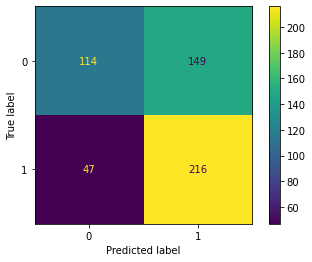

In [13]:
plot_confusion_matrix(model, reddit_X_test, reddit_y_test) 
plt.show()

In [14]:
print('false positive error rate - rate of predicting a parent post as a feminist post:', fp / (fp + tn))
print('false negative error rate - rate of predicting a feminist post as a parent post:', fn / (fn + tp))

false positive error rate - rate of predicting a parent post as a feminist post: 0.5665399239543726
false negative error rate - rate of predicting a feminist post as a parent post: 0.17870722433460076


<br>

Te confision matrix results shows the big difference between false positive error rate and false negative error rate. This shows that our model is more towards predicting a post as a feminist post than a parent post. 

This problem is probably because of the differences between the distribution of mumsnet data (used for training the model), and reddit data. To aleviate this problem, we apply a Domain Adaptation model on both trainng data and test data, and re-train our model. 

<br>

# Subspace Alignment
In this tutorial, we apply an unsupervised DA solution proposed in [1], as subspace alignment, to learn a mapping function which aligns the source distribution with the target one, which in our case source data is mumsnet data and target data is reddit data (the unsupervised setting means that the training data only need the labelled examples from source data and unlabeled target examples).


<br>
<br>

let's first prepare the source and target data (mumsnet and reddit data):

In [15]:
mumsnet_df = read_csv(DBDIR + Mumsnet_DB)

In [16]:
def get_train_set(df, batch_size, verbose=False):
    df = df.sample(frac=1)
    
    if verbose:
        print('number of between participants is:{}'.format(len(between_set.user_id.unique())))
        
    posts_fem = df[df['forum_id'] == 1]
    posts_par = df[df['forum_id'] == 0]
    
    
    if min(posts_fem.shape[0], posts_par.shape[0]) < batch_size :
        batch_size = min(posts_fem.shape[0], posts_par.shape[0])

    # buiding train set by randomly selecting posts from feminist and parent forums
    posts_fem = df[df['forum_id'] == 1][:batch_size]
    posts_par = df[df['forum_id'] == 0][:batch_size]
    
    trainDB = pd.concat([posts_fem, posts_par])
    
    
    return trainDB

In [17]:
mumsnet_trainDB = get_train_set(mumsnet_df, batch_size=50000)
print('\ntrain set size:{}'.format(mumsnet_trainDB.shape[0]))


train set size:100000


In [18]:
mumsnet_df_rest = mumsnet_df.loc[~mumsnet_df.msg_id.isin(mumsnet_trainDB.msg_id)].copy(deep=True)
mumsnet_between_p, mumsnet_within_p = separating_users(mumsnet_df_rest)
mumsnet_within_posts = mumsnet_df_rest.loc[mumsnet_df_rest.user_id.isin(mumsnet_within_p)]
mumsnet_testDB = extract_testcases(mumsnet_within_posts)


In [19]:
mumsnet_trainDB = mumsnet_trainDB.reset_index(drop=True)
mumsnet_testDB = mumsnet_testDB.reset_index(drop=True)

print(mumsnet_trainDB.shape)
print(mumsnet_testDB.shape)

(100000, 84)
(4002, 84)


<br>

we usually get the train instances as a random samples from all data, however, as the number of within participants are quite low in reddit data, we don't want to loose more of them by choosing their posts in train data. So, here, we choose the reddit_trainDB only from between posts:

In [20]:
reddit_between_posts = reddit_df.loc[reddit_df.user_id.isin(reddit_between_p)]
reddit_trainDB = get_train_set(reddit_between_posts, batch_size=50000)

In [21]:
reddit_trainDB = reddit_trainDB.reset_index(drop=True)
reddit_testDB = reddit_testDB.reset_index(drop=True)

print(reddit_trainDB.shape)
print(reddit_testDB.shape)

(51366, 83)
(526, 83)


In [22]:
source_train_X, source_train_y = mumsnet_trainDB[ALL_STYLISTIC_FEATURES], mumsnet_trainDB['forum_id']
ssource_test_X, source_test_y = mumsnet_testDB[ALL_STYLISTIC_FEATURES], mumsnet_testDB['forum_id']

target_train_X, target_train_y = reddit_trainDB[ALL_STYLISTIC_FEATURES], reddit_trainDB['forum_id']
target_test_X, target_test_y = reddit_testDB[ALL_STYLISTIC_FEATURES], reddit_testDB['forum_id']


<br>

## Tuning the efficient number of eigenvectors (d_optimum)

Even though both the source and target data (mumsnet and reddit data) lie in the same 𝐷-dimensional space (44 LIWC stylistic features), they have been drawn according to different distributions. Consequently, rather than working on the original data themselves, we learn the shift between these two domains. The goal is to shift both the source and target domain into a shared d-dimensional space. But, how we calculate this optimum d-dimensional space?


<br>


We go through this process step-by-step: 

1- First, we transform source and target data in the form of a D-dimensional z-normalized vector (i.e. of zero mean and unit standard deviation), and then, using PCA, for each domain (mumsnet and ressit data), D eigenvectors which are ordered based on the eigenvalues.

2- Second, we calculate the upper bound of the dimensionality (d-max) of the shared space.

3- Third, Afterwards, we consider the subspaces of dimensionality from d = 1 to d_max and select the
best d (d_optimum) that minimizes the classification error using a 10 fold cross-validation over the labelled source data (mumsnet data). 

4- Finally, we shift both source and target data into the shared subspace with the d-optimum dimensions.


<br>
<br>

###### step1

In [23]:
import numpy as np
from scipy import stats
from numpy import linalg as LA
import copy
import math


# using Principal Component Analysis (PCA) to identify eigenvectors and eigenvalues
def PrincipleC(X, n):
    C = np.dot(np.matrix(X).transpose(), np.matrix(X) ) /X.shape[1]
    Lambda, U = LA.eig(C)
    indices = np.argsort(Lambda)[::-1]
    Lambda = [Lambda[i] for i in indices]
    U = U[:, indices]
    return U[: ,:n], Lambda[:n]



# transforming the source and target data in the form of a D-dimensional z-normalized vector
# and calling the PrincipleC
def get_eigenvectors(X_source, X_target, dimensions):
    #transform the data in the form of a D-dimensional z-normalized vector
    X1 = stats.zscore(X_source)
    X2 = stats.zscore(X_target)
    
    #extract the eigenvectors and eigenvalues
    X_s, Lambda_s = PrincipleC(X1.copy(), dimensions)
    X_t, Lambda_t = PrincipleC(X2.copy(), dimensions)
    
    
    return X_s, X_t, Lambda_s, Lambda_t

###### step2

In [24]:
#this function calculates the upper bound of d - maximum number of dimensions
def get_max_dimension(X_source, X_target, dimensions, verbose=True):
    # getting the eigenvectors and eigenvalues
    X_s, X_t, Lambda_s, Lambda_t = get_eigenvectors(X_source, X_target, dimensions)

    lambdas = []
    gammas = []
    B = 100 #a random positive number
    delta = 0.1
    n_min = np.minimum(X_source.shape[0], X_target.shape[0])
    for i in range(0, dimensions-1):
        lmin = np.minimum(Lambda_t[i]-Lambda_t[i+1], Lambda_s[i]-Lambda_s[i+1])
        gamma = (1+np.sqrt(math.log(2/delta)/2))*((16*np.power(i+1, 3/2)*B)/(np.sqrt(n_min)*lmin))
        lambdas.append({'d': i+1, 'lmin': copy.deepcopy(lmin)})
        gammas.append(copy.deepcopy(gamma))

    gamma = max(gammas)

    d_max = 1
    for dic_ in lambdas:
        
        d = dic_['d']
        lmin = dic_['lmin']
        upper_b = (1+np.sqrt(math.log(2/delta)/2))*((16*np.power(d, 3/2)*B)/(gamma*np.sqrt(n_min)))
        if lmin >= upper_b:
            d_max = d
            
    if verbose:
        print('\n upper dimension bound (d_max):', d_max)
    return d_max

In [25]:

d_max = get_max_dimension(source_train_X[ALL_STYLISTIC_FEATURES].copy(deep=True), 
                          target_train_X[ALL_STYLISTIC_FEATURES].copy(deep=True), source_train_X.shape[1])


 upper dimension bound (d_max): 43


by running the code above, we calculate the upper bound of d, as d_max. In order to calculate the efficient number of dimensions, we run the function get_optimum_dimensions where for dimensionality from d = 1 to d_max, we shiftf source and target data accordignly (function align) and calculate the accuracy of training and testing on source data (mumsnet data) using 10 fold cross validation. The optimum dimensionality is the one which results in the highest accuracy on source data. 

<br>



###### step3

In [26]:

from sklearn.linear_model import LogisticRegression


def Logistic_Regression(grid_search=False):
    clf = LogisticRegression(solver='lbfgs', max_iter = 2000)

    if grid_search:
        tuned_parameters = [{'C': [1e-3, 1e-2, 1e-1, 1]}]
        clf = GridSearchCV(LogisticRegression(solver='lbfgs'), tuned_parameters, cv=10,
                           scoring='accuracy', n_jobs=-1)

    return clf


def train(X_train, y_train, verbose=False):
    model = Logistic_Regression()
    model.fit(X_train, y_train)


    if verbose:
        print('model is trained')

    return model

In [27]:
from sklearn.model_selection import StratifiedKFold

# the main function for shifting the source and target distributions
def align(X_1, X_2, dim):
    X_1 = stats.zscore(X_1)
    X_2 = stats.zscore(X_2)

    X_s, Lambda_s = PrincipleC(X_1.copy(), dim)
    X_t, Lambda_t = PrincipleC(X_2.copy(), dim)

    X_a = np.matrix(X_s) * np.matrix(X_s).transpose() * np.matrix(X_t)

    S_a = np.matrix(X_1) * np.matrix(X_a)

    T_t = np.matrix(X_2) * np.matrix(X_t)

    return S_a, T_t


# cross validation
def test_cross_validation(df, label):
    cv = StratifiedKFold(n_splits=10, shuffle=True)
    y = df[label].values
    X = df.drop(columns=[label]).values
    accuracy = []
    for tr, te in cv.split(X, y):
        clf = train(X[tr], y[tr])
        acc_ = test(clf, X[te], y[te])
        accuracy.append(copy.deepcopy(acc_))
    return np.mean(accuracy)


# calculating the optimum number of dimensions
def get_optimum_dimension(d_max, X_source, y_source, X_target, label='forum_id', verbose=False):
    acc_max = 0
    d_optimum = 1
    for j in range(1, d_max + 1):
        X_s, X_t = align(copy.deepcopy(X_source), copy.deepcopy(X_target), j)
        train_df = pd.concat([pd.DataFrame(X_s), y_source], axis=1)
        acc_ = test_cross_validation(train_df, label=label)
        if acc_ >= acc_max:
            acc_max = acc_
            d_optimum = j
    if verbose:
        print('\n maximum accuracy for training and testing on source data:', acc_max)
        print('\n optimum dimensions:', d_optimum)

    return d_optimum

In [28]:
# calculate the optimum dimensionality
d_optimum = get_optimum_dimension(d_max, source_train_X[ALL_STYLISTIC_FEATURES].copy(deep=True), source_train_y, 
                                  target_train_X[ALL_STYLISTIC_FEATURES].copy(deep=True), verbose=True)


 maximum accuracy for training and testing on source data: 0.8447899999999999

 optimum dimensions: 43


<br>

Now that we calculated the optimum dimensionality, we can transform both source and target (mumsnet and reddit) data in to the shared subspace:


###### step4

In [29]:
def get_shared_subspace(X_1, X_2, d_optimum):
    scaler_1 = StandardScaler().fit(X_1)
    X_1 = scaler_1.transform(X_1)

    scaler_2 = StandardScaler().fit(X_2)
    X_2 = scaler_2.transform(X_2)

    X_s, Lambda_s = PrincipleC(X_1.copy(), d_optimum)
    X_t, Lambda_t = PrincipleC(X_2.copy(), d_optimum)

    X_a = np.matrix(X_s) * np.matrix(X_s).transpose() * np.matrix(X_t)

    return X_a, X_t, scaler_1, scaler_2

In [30]:

# create the shared subspace according to the optimum number of dimensions
X_a, X_t, scaler_a, scaler_t = get_shared_subspace(source_train_X.copy(deep=True),target_train_X.copy(deep=True), 
                                                   d_optimum)

# transform the source training data
X_1 = scaler_a.transform(source_train_X)
t_source_train_X = np.matrix(X_1) * np.matrix(X_a)


# transform the target test data
X_2 = scaler_t.transform(target_test_X)
t_target_test_X = np.matrix(X_2) * np.matrix(X_t)



<br>
<br>


### Training and testing on the transformed data
With both source training data and target test data are now transofrmed into a shared subspace, we re-train our model using the transformed mumsnet training data, and apply it on trasformed reddit test data:

In [31]:
# train a model using transformed source train data
print('\n training a model on transformed source data ...')
retrained_model = train(pd.DataFrame(t_source_train_X), source_train_y)

print('\n test the model on transformed target test data: \n')
# test the model on transformed target test data
c = test(retrained_model, pd.DataFrame(t_target_test_X), target_test_y, verbose=True)


 training a model on transformed source data ...

 test the model on transformed target test data: 

test accuracy:0.6901140684410646 test AUC :0.719296216513178


<br> 

As you can see, the AUC hasn't channged much, however, the accuracy has improved substantially. Let's study the results by taking a look at the confusion matrix results:

In [32]:
predict_abs = retrained_model.predict(pd.DataFrame(t_target_test_X))


tn, fp, fn, tp = confusion_matrix(target_test_y, predict_abs).ravel()
print('false positive error rate - rate of predicting a parent post as a feminist post:', fp / (fp + tn))
print('false negative error rate - rate of predicting a feminist post as a parent post:', fn / (fn + tp))

false positive error rate - rate of predicting a parent post as a feminist post: 0.29277566539923955
false negative error rate - rate of predicting a feminist post as a parent post: 0.3269961977186312


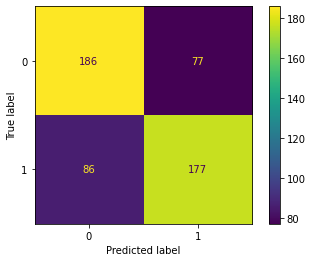

In [35]:
plot_confusion_matrix(retrained_model, t_target_test_X, target_test_y) 
plt.show()

<br>

As you can see, the error rates are now balanced towards both feminist and parent posts, which was the objective of this part of the tutorial.